In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
batch_size = 256
epochs = 30
lr = 1e-4
data_set_root = "../../datasets"

# We split an image up into patches of 4x4, and each patch is treated like a token in the Transformer.
# This allows the model to capture local features while still being able to understand interactions between different regions of the image through self-attention.
patch_size = 4

In [ ]:
# Normalizing with the dataset mean and std
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10), # Automatic data augmentation (rotations, translations, color adjustments, etc.)
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

In [ ]:
train_data = datasets.CIFAR10(data_set_root,
                              train=True,
                              download=True,
                              transform=transform)
test_data = datasets.CIFAR10(data_set_root,
                             train=False,
                             download=True,
                             transform=test_transform)

validation_split = 0.9

n_train = int(len(train_data) * validation_split)
n_validation = len(train_data) - n_train

train_data, valid_data = torch.utils.data.random_split(train_data, [n_train, n_validation], generator=torch.Generator().manual_seed(42))

100%|██████████| 170M/170M [00:01<00:00, 97.0MB/s]


Extracting ../../datasets/cifar-10-python.tar.gz to ../../datasets
Files already downloaded and verified


In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


In [ ]:
train_loader = dataloader.DataLoader(train_data,
                                     shuffle=True,
                                     batch_size=batch_size)
valid_loader = dataloader.DataLoader(valid_data,
                                     batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data,
                                     batch_size=batch_size)

In [ ]:
class_names = train_data.dataset.classes

In [ ]:
def extract_patches(image_tensor, patch_size=8):
  # Patches are small, fixed-size regions of the input image that the model treats as individual tokens
  bs, c, h, w = image_tensor.size()

  unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size) # Slices the images into patches with patch_size x patch_size
  unfolded = unfold(image_tensor)

  # Output shape: (batch_size, num_patches, patch_dim)
  unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
  return unfolded

In [ ]:
data_iter = next(iter(test_loader))

test_images, test_labels = data_iter

In [ ]:
img_size = test_images.shape[2]
img_size

32

Sequence Length 64


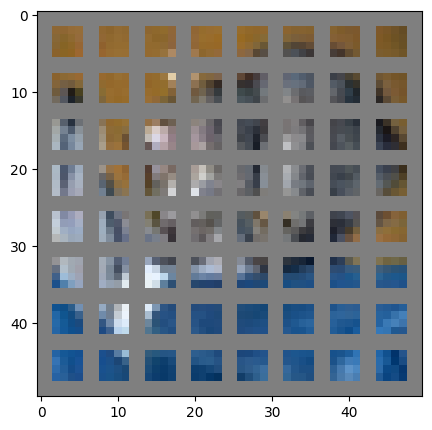

In [ ]:
# Visualize patches of the first image
patches = extract_patches(test_images, patch_size=patch_size)
patches_square = patches.reshape(test_images.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
# Positional Encoding
class PositionalEncoding(nn.Module):
  def __init__(self,
               d_model: int,
               seq_length: int):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    seq_length: length of a sequence
    """
    super().__init__()

    pe = torch.zeros(seq_length, d_model) # (seq_length, d_model)

    # Create position column
    k = torch.arange(0, seq_length).unsqueeze(dim=1)

    # Use the log version of the function for positional encodings
    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

    # Use sine for the even indices and cosine for the odd indices
    pe[:, 0::2] = torch.sin(k * div_term)
    pe[:, 1::2] = torch.cos(k * div_term)

    pe = pe.unsqueeze(dim=0) # Add the batch dimension

    # We use a buffer because the positional encoding is fixed and not a model paramter that we want to be updated during backpropagation.
    self.register_buffer("pe", pe) # Buffers are saved with the model state and are moved to the correct device

  def forward(self, x):
    # x shape: (batch_size, seq_length, d_model)
    # Add the positional encoding to the embeddings that are passed in
    return x + self.pe[:, :x.size(1)]

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               in_channels: int = 3,
               patch_size: int = 4,
               d_model: int = 768,
               img_size: int = 28):
    super().__init__()

    self.patch_size = patch_size
    self.projection = nn.Sequential(
      nn.Conv2d(in_channels, d_model, kernel_size=patch_size, stride=patch_size),
      # Rearranging from (batch_size, d_model, h, w) to (batch_size, h*w, d_model)
      # Flatten the spatial dimensions (h and w) into one dimension because each patch is treated as a token, so it must be flattened from 2D to 1D
      nn.Flatten(2)
    )

    # Initialize a learnable class token with a size of (1, 1, d_model)
    self.cls_token = nn.Parameter(torch.rand(1, 1, d_model))

    # Calculate the total sequence length (patches + 1 for the class token)
    seq_length = (img_size // patch_size) ** 2 + 1

    self.pos_embed = PositionalEncoding(d_model=d_model, seq_length=seq_length)

  def forward(self, x):
    # x shape: (batch, channels, height, width)
    b, c, h, w = x.shape

    # Creates a sequence of patch embeddings with shape (batch_size, num_patches, d_model)
    x = self.projection(x).transpose(1, 2)

    # Expand the class token for each image in the batch: (batch_size, 1, d_model)
    cls_token = self.cls_token.expand(b, -1, -1)

    # Concatenate the class token to the patch embeddings along the sequence dimension
    x = torch.cat([cls_token, x], dim=1)

    # Add positional encodings
    x = self.pos_embed(x)

    return x

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()
    assert d_model % n_heads == 0 # We want to make sure that the dimensions are split evenly among the attention heads.
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_key = d_model // n_heads

    self.Wq = nn.Linear(d_model, d_model) # Learnable weights for query
    self.Wk = nn.Linear(d_model, d_model) # Learnable weights for key
    self.Wv = nn.Linear(d_model, d_model) # Learnable weights for value

    self.dropout = nn.Dropout(p=0.1)

  def forward(self, x):
    """
    x: (batch_size, length, d_model)
    """
    batch_size, n, d_input = x.shape

    # Matrix multiplication for Q, K, and V tensors
    Q = self.Wq(x)
    K = self.Wk(x)
    V = self.Wv(x)

    # Split each tensor into heads
    Q = Q.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, q_length, d_key)
    K = K.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, k_length, d_key)
    V = V.view(batch_size, -1, self.n_heads, self.d_key).permute(0, 2, 1, 3) # (batch_size, n_heads, v_length, d_key)

    # Scaled dot product
    scaled_dot_product = torch.matmul(Q, K.permute(0, 1, 3, 2) / math.sqrt(self.d_key)) # K^T becomees (batch_size, n_heads, d_key, k_length)

    # Softmax function for attention probabilities
    attention_probs = torch.softmax(scaled_dot_product, dim=-1)

    # Multiply by V to get attention with respect to the values
    output = torch.matmul(self.dropout(attention_probs), V)

    # Reshape attention back to (batch_size, q_length, d_model)
    output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)

    return output

In [ ]:
class PositionwiseFeedForward(nn.Module):
  def __init__(self, d_model: int):
    """
    d_model: dimensions of the embeddings (number of values in each embedding vector)
    d_ffn: dimensions of the feed-forward network
    dropout: probability of dropout
    """
    super().__init__()

    self.ffn = nn.Sequential(
        nn.Linear(in_features=d_model, out_features=(d_model * 4)),
        nn.ReLU(),
        nn.Linear(in_features=(d_model * 4), out_features=d_model),
        nn.Dropout(p=0.1)
    )

  def forward(self, x):
    return self.ffn(x)

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self, d_model, n_heads):
    super().__init__()

    self.attention = MultiHeadAttention(d_model=d_model, n_heads=n_heads)
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(0.1)
    self.ffn = PositionwiseFeedForward(d_model=d_model)
    self.layer_norm_2 = nn.LayerNorm(d_model)

  def forward(self, x):
    # Multi-Head Self-Attention
    x = x + self.dropout(self.attention(self.layer_norm_1(x))) # Residual Addition and Layer Normalization
    # Feed-forward Network
    x = x + self.dropout(self.ffn(self.layer_norm_2(x))) # Residual Addition and Layer Normalization

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               n_layers,
               img_size,
               d_model,
               patch_size,
               n_heads,
               num_classes):
    super().__init__()

    self.patch_emb = PatchEmbedding(patch_size=patch_size, img_size=img_size, d_model=d_model)
    self.layers = nn.ModuleList([EncoderBlock(d_model=d_model, n_heads=n_heads) for layer in range(n_layers)])
    self.ff_out = nn.Linear(d_model, num_classes)

  def forward(self, x):
    # x: (batch_size, channels, height, width)
    x = self.patch_emb(x) # (batch_size, num_patches + 1, emb_dim) The +1 comes from the class token

    for layer in self.layers:
      x = layer(x)

    return self.ff_out(x[:, 0, :]) # Get the class token with a size of d_model for the final class prediction

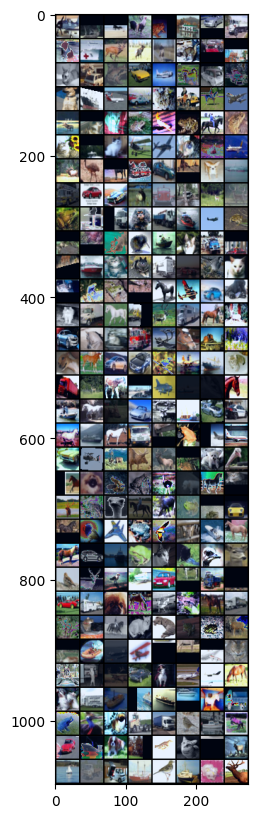

In [ ]:
# Create a dataloader itterable object
(train_images, train_labels) = next(iter(train_loader))

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

In [ ]:
model = VisionTransformer(n_layers=8,
                          img_size=img_size,
                          d_model=768,
                          patch_size=4,
                          n_heads=6,
                          num_classes=len(class_names)).to(device)

In [ ]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print(f"This Model Has {num_model_params} Parameters")

This Model Has 52024330 Parameters


In [ ]:
out = model(test_images.to(device))
out.shape

torch.Size([256, 10])

In [ ]:
optimizer = optim.AdamW(params=model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                    T_max=epochs,
                                                    eta_min=0)

In [ ]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fn, loss_logger):
  model.train()

  for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
    x, y = x.to(device), y.to(device)
    output = model(x)

    # Calculate loss using loss function
    loss = loss_fn(output, y)

    optimizer.zero_grad()
    loss.backward()

    # Gradient Clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()

    loss_logger.append(loss.item())

  return model, optimizer, loss_logger

In [ ]:
def evaluate(model, device, loader):
  epoch_acc = 0
  model.eval()

  with torch.inference_mode():
      for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
        x, y = x.to(device), y.to(device)
        output = model(x.to(device))

        # Log the cumulative sum of the acc
        epoch_acc += (output.argmax(1) == y.to(device)).sum().item()

  # Return the accuracy from the epoch
  return epoch_acc / len(loader.dataset)

In [ ]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [ ]:
valid_acc = 0
train_acc = 0

best_valid_acc = float('inf')
model_path = "vision_transformer_model.pt"

if os.path.exists(model_path):
  print(f"Loading model from {model_path}...")
  model.load_state_dict(torch.load(model_path, map_location=device))
else:
  print("No saved model found. Starting training...")

  pbar = trange(0, epochs, leave=False, desc="Epoch")
  for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    model, optimizer, training_loss_logger = train(model=model,
                                                  optimizer=optimizer,
                                                  loader=train_loader,
                                                  device=device,
                                                  loss_fn=loss_fn,
                                                  loss_logger=training_loss_logger)

    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)

    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)

    message = f"Epoch: {epoch + 1} | Train Acc: {train_acc} | Validation Acc: {valid_acc}"

    if valid_acc > best_valid_acc:
      best_valid_loss = valid_acc
      torch.save(model.state_dict(), model_path)
      message += " --> STORED"

    print(message)

    # Reduce learning rate
    lr_scheduler.step()

Loading model from vision_transformer_model.pt...


<ipython-input-35-8a87b1402aff>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [ ]:
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

The total test accuracy is: 74.98%


Predicted Values
 ['cat', 'ship', 'airplane', 'airplane', 'frog', 'frog', 'cat', 'frog']
True Values
 ['cat', 'ship', 'ship', 'airplane', 'frog', 'frog', 'automobile', 'frog']


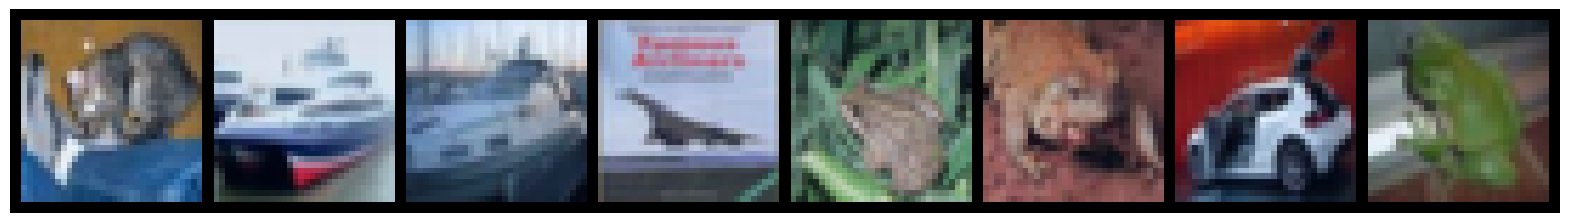

In [ ]:
with torch.inference_mode():
  fx = model(test_images[:8].to(device))
  pred = fx.argmax(-1)

plt.figure(figsize = (20,10))
plt.axis(False)
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", [class_names[x] for x in list(pred.cpu().numpy())])
print("True Values\n", [class_names[x] for x in list(test_labels[:8].numpy())])

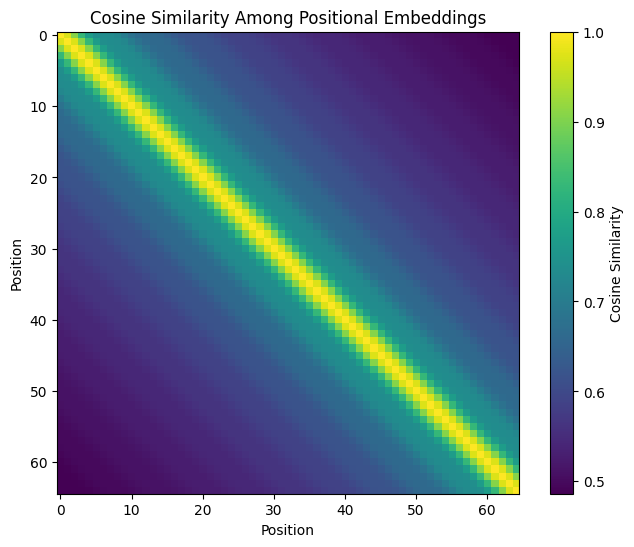

In [ ]:
pos_emb = model.patch_emb.pos_embed.pe.squeeze(0)  # shape: (seq_length, d_model)
pos_emb_np = pos_emb.cpu().numpy()  # Convert to numpy for further processing

# Normalize each positional embedding vector.
norms = np.linalg.norm(pos_emb_np, axis=1, keepdims=True)
normalized_pos_emb = pos_emb_np / norms

# Compute the cosine similarity matrix.
cosine_sim = np.dot(normalized_pos_emb, normalized_pos_emb.T)

plt.figure(figsize=(8, 6))
plt.imshow(cosine_sim, cmap="viridis")
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity Among Positional Embeddings")
plt.xlabel("Position")
plt.ylabel("Position")
plt.show()